# RGI-07: Region 08 (Scandinavia)
##### F. Maussion & S. Galos, August 2021

No changes to RGI6

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import os
from utils import mkdir

## Files and storage paths

In [8]:
# Region of interest
reg = 8

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '07_rgi60_Scandinavia.zip')

### Load the input data

In [9]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

## Apply selection criteria to reproduce RGI-6 for this region and check result

### Step 1: extract RGI6 from GLIMS data and do a check

In [10]:
#...extract RGI06 from GLIMS based on 'geog_area'
RGI_ss = shp.loc[shp['geog_area']=='Randolph Glacier Inventory; Umbrella RC for merging the RGI into GLIMS']

### extraction of RGI-6 via 'geog_area' is not possible so try to reproduce it in an other way

In [11]:
# do that based on relevant submission IDs (611, 362, 363, 364, 365)
RGI_ss = (shp.loc[shp['subm_id'].isin([611, 362, 363, 364, 365])])

#### load reference data (here RGI6) to enable comparison

In [12]:
# Just to know the name of the file to open from zip
import zipfile
with zipfile.ZipFile(rgi6_reg_file, "r") as z:
    for f in z.filelist:
        if '.shp' in f.filename:
            fname = f.filename

# load reference data
ref_odf = gpd.read_file('zip://' + rgi6_reg_file + '/' + fname)

#### Number of elements (differences do not necessarily depict major problems)

In [13]:
print('Number of glaciers in new RGI subset:', len(RGI_ss))
print('Number of glaciers in reference data:', len(ref_odf))
print('Difference:', len(RGI_ss)-len(ref_odf))

Number of glaciers in new RGI subset: 3417
Number of glaciers in reference data: 3417
Difference: 0


#### check for dublicate glacier IDs

In [14]:
print('Dublicate IDs in RGI-6:', len(ref_odf)-len(ref_odf['GLIMSId'].unique()))
print('Dublicate IDs in reproduction:', len(RGI_ss)-len(RGI_ss['glac_id'].unique()))

Dublicate IDs in RGI-6: 8
Dublicate IDs in reproduction: 11


#### Check for 'nominal glaciers' in the RGI6 original data and delete them from new RGI subset from GLIMS if they are in there 

In [19]:
# how many nominals in RGI06 (identifiable via 'Status' attribute in RGI 06)
nom = ref_odf.loc[ref_odf.Status == 2].copy()
len(nom)

4

In [20]:
nom

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,area
0,RGI60-08.00001,G033830E67930N,-9999999,-9999999,33.83,67.93,8,1,0.03,235,...,180,2,0,0,0,9,9,SU4C01001001 1,"POLYGON ((33.83233 67.92999, 33.83229 67.92984...",29847.934864
1,RGI60-08.00002,G033500E67870N,-9999999,-9999999,33.50,67.87,8,1,0.03,228,...,177,2,0,0,0,9,9,SU4C01001002 2,"POLYGON ((33.50232 67.86999, 33.50229 67.86984...",29847.934401
2,RGI60-08.00003,G033750E67820N,-9999999,-9999999,33.75,67.82,8,1,0.02,701,...,135,2,0,0,0,9,9,SU4C01001003 3,"POLYGON ((33.75189 67.81999, 33.75186 67.81987...",19898.621132
3,RGI60-08.00004,G033770E67830N,-9999999,-9999999,33.77,67.83,8,1,0.02,671,...,125,2,0,0,0,9,9,SU4C01001004 4,"POLYGON ((33.77189 67.82999, 33.77187 67.82987...",19898.629255


In [21]:
# drop nominal glaciers from new RGI subset
RGI_ss = (RGI_ss.loc[~RGI_ss['glac_id'].isin(nom['GLIMSId'])])

#### Total area

In [22]:
# add an area field to RGI_ss and reference data
RGI_ss['area'] = RGI_ss.to_crs({'proj':'cea'}).area
ref_odf['area'] = ref_odf.to_crs({'proj':'cea'}).area
nom['area'] = nom.to_crs({'proj':'cea'}).area

In [24]:
# print and compare area values
Area_Rep = RGI_ss['area'].sum()/1000000
print('Area Rep [km²]:', Area_Rep)
Area_RGI6 = ref_odf['area'].sum()/1000000
print('Area RGI6 [km²]:', Area_RGI6)
Area_nom = nom['area'].sum()/1000000
print('Area Nom [km²]:', Area_nom)
d = (Area_Rep + Area_nom - Area_RGI6)
d_perc = (d/Area_Rep*100)
print('Area difference [km²]:',d,'/','percentage:', d_perc)

Area Rep [km²]: 2952.2452512413574
Area RGI6 [km²]: 2949.088114785122
Area Nom [km²]: 0.09949311965215754
Area difference [km²]: 3.256629575887928 / percentage: 0.11031026553497149


### result of check (RGI from Glims global data base vs. RGI06 original):
#### difference in number of glaciers: 0
#### dublicate IDs: 8 in RGI-6, 11 in reproduced data
#### nominal glaciers: 4
#### area difference: 3.2 km² / 0.1 % 
#### general comment: in general reproduction works... area differences obviously from outline revisions (G016345E67139N and G018055E68083N), as well as vertex shifts between data-sets. Glacier G008363E61600N is wrongly located (shifted to north) in RGI-6, correct in GLIMS. 

## Write out and tar 

In [22]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
RGI07_reg10.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))## Write out and tar 

Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', 'C:/Daten/Projekte/RGI/RGI_7/rgi7_data/l3_rgi7a_tar/RGI10.tar.gz', '-C', 'C:/Daten/Projekte/RGI/RGI_7/rgi7_data/l3_rgi7a', 'RGI10'], returncode=0)


## Find missing glaciers 

In [25]:
from utils import haversine
import numpy as np
import progressbar

In [26]:
def xy_coord(geom):
    """To compute CenLon CenLat ourselves"""
    x, y = geom.xy
    return x[0], y[0]

In [27]:
df_ref = ref_odf.copy()
rgi7 = RGI_ss.copy()

In [28]:
# Remove nominal
df_ref = df_ref.loc[df_ref.Status != 2].copy()

In [29]:
# compute CenLon CenLat ourselves
rp = df_ref.representative_point()

coordinates = np.array(list(rp.apply(xy_coord)))
df_ref['CenLon'] = coordinates[:, 0]
df_ref['CenLat'] = coordinates[:, 1]

In [30]:
df_ref_orig = df_ref.copy()

In [31]:
# Loop over all RGI7 glaciers and find their equivalent in ref
df_ref = df_ref_orig.copy()
not_found = {}
to_drop = []
for i, (ref_area, lon, lat) in progressbar.progressbar(enumerate(zip(rgi7['area'].values, rgi7.CenLon.values, rgi7.CenLat.values)), max_value=len(rgi7)):
#     dist = haversine(lon, lat, df_ref.CenLon.values, df_ref.CenLat.values)
    dist = (lon - df_ref.CenLon.values)**2 + (lat - df_ref.CenLat.values)**2 
    found = False
    for j in np.argsort(dist)[:10]:
        s6 = df_ref.iloc[j]
        if np.allclose(s6['area'], ref_area, rtol=0.001):
            found = True
            to_drop.append(s6.name)
            break
    if not found:
        not_found[i] = df_ref.iloc[np.argsort(dist)[:10]]
    if len(to_drop) > 1000:
        df_ref.drop(labels=to_drop, inplace=True)
        to_drop = []
df_ref.drop(labels=to_drop, inplace=True)

100% (3417 of 3417) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


In [32]:
print(len(not_found), len(df_ref))

7 3


In [33]:
pb_rgi7 = rgi7.iloc[list(not_found.keys())]

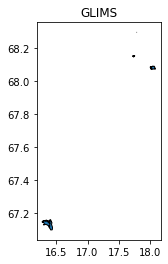

In [34]:
pb_rgi7.plot(edgecolor='k');
plt.title('GLIMS');

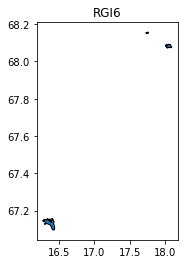

In [35]:
df_ref.plot(edgecolor='k');
plt.title('RGI6');

In [36]:
# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_problem_glaciers'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_problem_glaciers_tar'))

In [37]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
pb_rgi7.to_file(dd + f'RGI{reg:02d}_glims.shp')
df_ref.to_file(dd + f'RGI{reg:02d}_ref.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_problem_glaciers_tar/RGI08.tar.gz', '-C', '../../rgi7_data/l3_problem_glaciers', 'RGI08'], returncode=0)
